> ##### <b>Sensitivity Test</b>

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
Tgs_filename = dir1 + '/Tgsmax_0621_FLUX_NS_PELT.csv'
Topt_model_filename = dir2 + '/01Oct24_Canopy_defaultLAI.csv'
Topt_NoAd_filename  = dir2 + '/Canopy_defaultLAI_noAdjust_09Dec24.csv'
Topt_Met_filename   = dir2 + '/Canopy_defaultLAI_noAdjust_noVPD_AllDayLit1250_14Jan25.csv'
Topt_Heat_filename  = dir2 + '/Canopy_defaultLAI_noAd_noVPD_AllDayLit1250_DtcCri_TdefAndT10_14Jan25.csv'

In [3]:
def read_csv(filename, outVar):
    # read csv, and document # of undetectable Topt
    # return the mean value
    df  = pd.read_csv(filename, index_col=0)
    num = np.nansum(np.isnan(df))
    
    # replace -9999 with no.nan
    # np.nan => undetectable Topt; -9999 => data inavailable (e.g., before site construction / failed QC)
    df  = df.replace(to_replace=-9999., value=np.nan)
    # exclude site with valid years less than 3
    # label   = (df.count(axis=1)<=2)
    df_mean = df.mean(axis=1).to_frame(name=outVar)
    # df_mean.loc[label] = np.nan
    return df_mean, num

In [4]:
def reg_ols(x, y):
    # OLS regression: default model
    x_cst = sm.add_constant(x)
    model = sm.OLS(y, x_cst)
    results = model.fit()
    R2 = round(results.rsquared,2)
    coef_df = pd.DataFrame({"params": results.params,   # coefficients
                            "t": round(results.tvalues,3),       # t-value
                            "p-values": round(results.pvalues,4) # p-value
                            })
    
    slope   = coef_df.iloc[1,0]
    itp     = coef_df.iloc[0,0]

    coef_df[['coef_0.025','coef_0.975']] = results.conf_int() # confidence interval

    slope_int = coef_df.iloc[1,0] - coef_df.iloc[1,3]
    itp_int   = coef_df.iloc[0,0] - coef_df.iloc[0,3]

    rmse = ((y-results.fittedvalues)**2).mean()**0.5
    print(coef_df)
    print("R2 and RMSE", R2, rmse)
    return slope, slope_int, itp, itp_int, R2, rmse

In [5]:
# read out and compute mean value
Tgs, _        = read_csv(Tgs_filename, "Tgs_mean")
Topt_model, _ = read_csv(Topt_model_filename, "Topt_model_mean")
Topt_NoAd, _  = read_csv(Topt_NoAd_filename,  "Topt_NoAd_mean")
Topt_Met, _   = read_csv(Topt_Met_filename,   "Topt_Met_mean")
Topt_Heat, _  = read_csv(Topt_Heat_filename,  "Topt_Heat_mean")

# merge
dfs = [Tgs, Topt_model,
       Topt_NoAd, Topt_Met,
       Topt_Heat
        ]
df = reduce(lambda x, y: pd.merge(x, y, on="site", how="inner"), dfs)
df = df.dropna(axis='index',how="any") 

In [6]:
# OLS regression
name1 = "CTRL"
slp1, slp_int1, itp1, itp_int1, rs1, rmse1 = reg_ols(df["Tgs_mean"], df["Topt_model_mean"])
name2 = "NoAdj"
slp2, slp_int2, itp2, itp_int2, rs2, rmse2 = reg_ols(df["Tgs_mean"], df["Topt_NoAd_mean"])
name3 = "NoAdj_NoVPD_uniPPFD"
slp3, slp_int3, itp3, itp_int3, rs3, rmse3 = reg_ols(df["Tgs_mean"], df["Topt_Met_mean"])
name4 = "NoAdj_NoVPD_uniPPFD_T10"
slp4, slp_int4, itp4, itp_int4, rs4, rmse4 = reg_ols(df["Tgs_mean"], df["Topt_Heat_mean"])

             params       t  p-values  coef_0.025  coef_0.975
const     12.143935  18.574       0.0   10.843030   13.444841
Tgs_mean   0.546584  17.728       0.0    0.485237    0.607930
R2 and RMSE 0.8 1.41983290599214
             params       t  p-values  coef_0.025  coef_0.975
const     15.330056  26.807       0.0   14.192200   16.467912
Tgs_mean   0.443874  16.459       0.0    0.390217    0.497532
R2 and RMSE 0.77 1.2418779955066954
             params       t  p-values  coef_0.025  coef_0.975
const     20.667789  28.189       0.0   19.208972   22.126606
Tgs_mean   0.327170   9.463       0.0    0.258377    0.395963
R2 and RMSE 0.53 1.5921809009350965
             params       t  p-values  coef_0.025  coef_0.975
const     26.054848  38.528       0.0   24.709314   27.400382
Tgs_mean   0.136727   4.287       0.0    0.073276    0.200178
R2 and RMSE 0.18 1.468541357267878


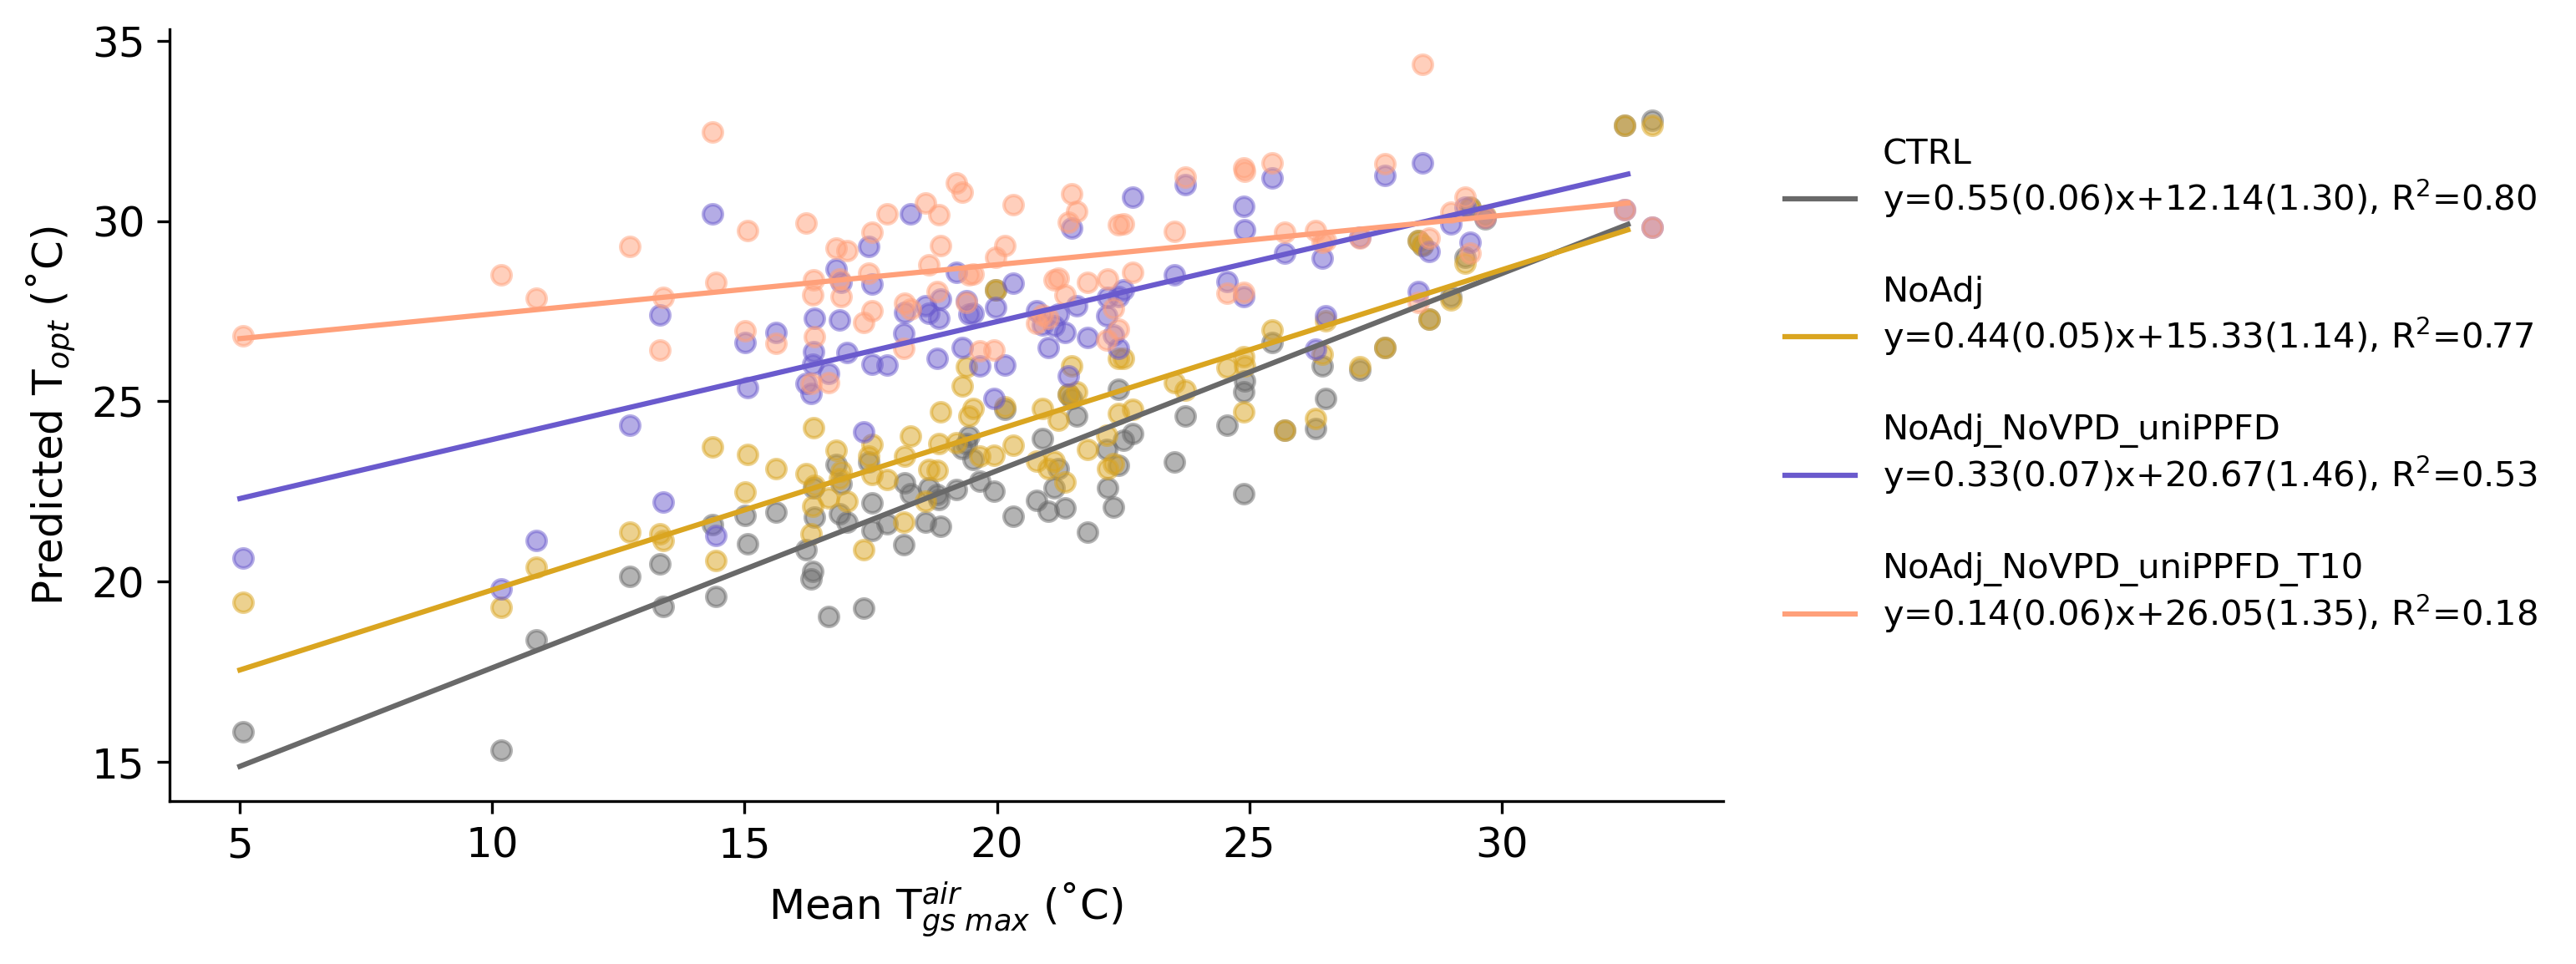

In [7]:
# reg lines
x  = np.arange(5, 33, 0.5)
y1 = slp1 * x + itp1
y2 = slp2 * x + itp2
y3 = slp3 * x + itp3
y4 = slp4 * x + itp4

# labels
str1 = name1 + "\n" + "y=%.2f(%.2f)x+%.2f(%.2f), R$^2$=%.2f\n"%(slp1, slp_int1, itp1, itp_int1, rs1)
str2 = name2 + "\n" + "y=%.2f(%.2f)x+%.2f(%.2f), R$^2$=%.2f\n"%(slp2, slp_int2, itp2, itp_int2, rs2)
str3 = name3 + "\n" + "y=%.2f(%.2f)x+%.2f(%.2f), R$^2$=%.2f\n"%(slp3, slp_int3, itp3, itp_int3, rs3)
str4 = name4 + "\n" + "y=%.2f(%.2f)x+%.2f(%.2f), R$^2$=%.2f\n"%(slp4, slp_int4, itp4, itp_int4, rs4)

# color
c1 = "dimgrey"
c2 = "goldenrod"
c3 = "slateblue"
c4 = "lightsalmon"

# scatter sz and linestyle
ap = 0.5
sz = 30
linestyle = "-"

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
# scatter
ax.scatter(df["Tgs_mean"], df["Topt_model_mean"], s=sz, alpha=ap, c=c1)
ax.scatter(df["Tgs_mean"], df["Topt_NoAd_mean"] , s=sz, alpha=ap, c=c2)
ax.scatter(df["Tgs_mean"], df["Topt_Met_mean"]  , s=sz, alpha=ap, c=c3)
ax.scatter(df["Tgs_mean"], df["Topt_Heat_mean"] , s=sz, alpha=ap, c=c4)
# reglines
ax.plot(x, y1, label=str1, c=c1)
ax.plot(x, y2, label=str2, c=c2)
ax.plot(x, y3, label=str3, c=c3)
ax.plot(x, y4, label=str4, c=c4)

ax.set_yticks(np.arange(15, 35.1, 5))
ax.set_xlabel("Mean T$_{gs\\ max}^{air}$ (˚C)", fontsize=12)
ax.set_ylabel("Predicted T$_{opt}$ (˚C)", fontsize=12)
ax.legend(bbox_to_anchor=(1.02, 0.9), loc='upper left', frameon=False)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

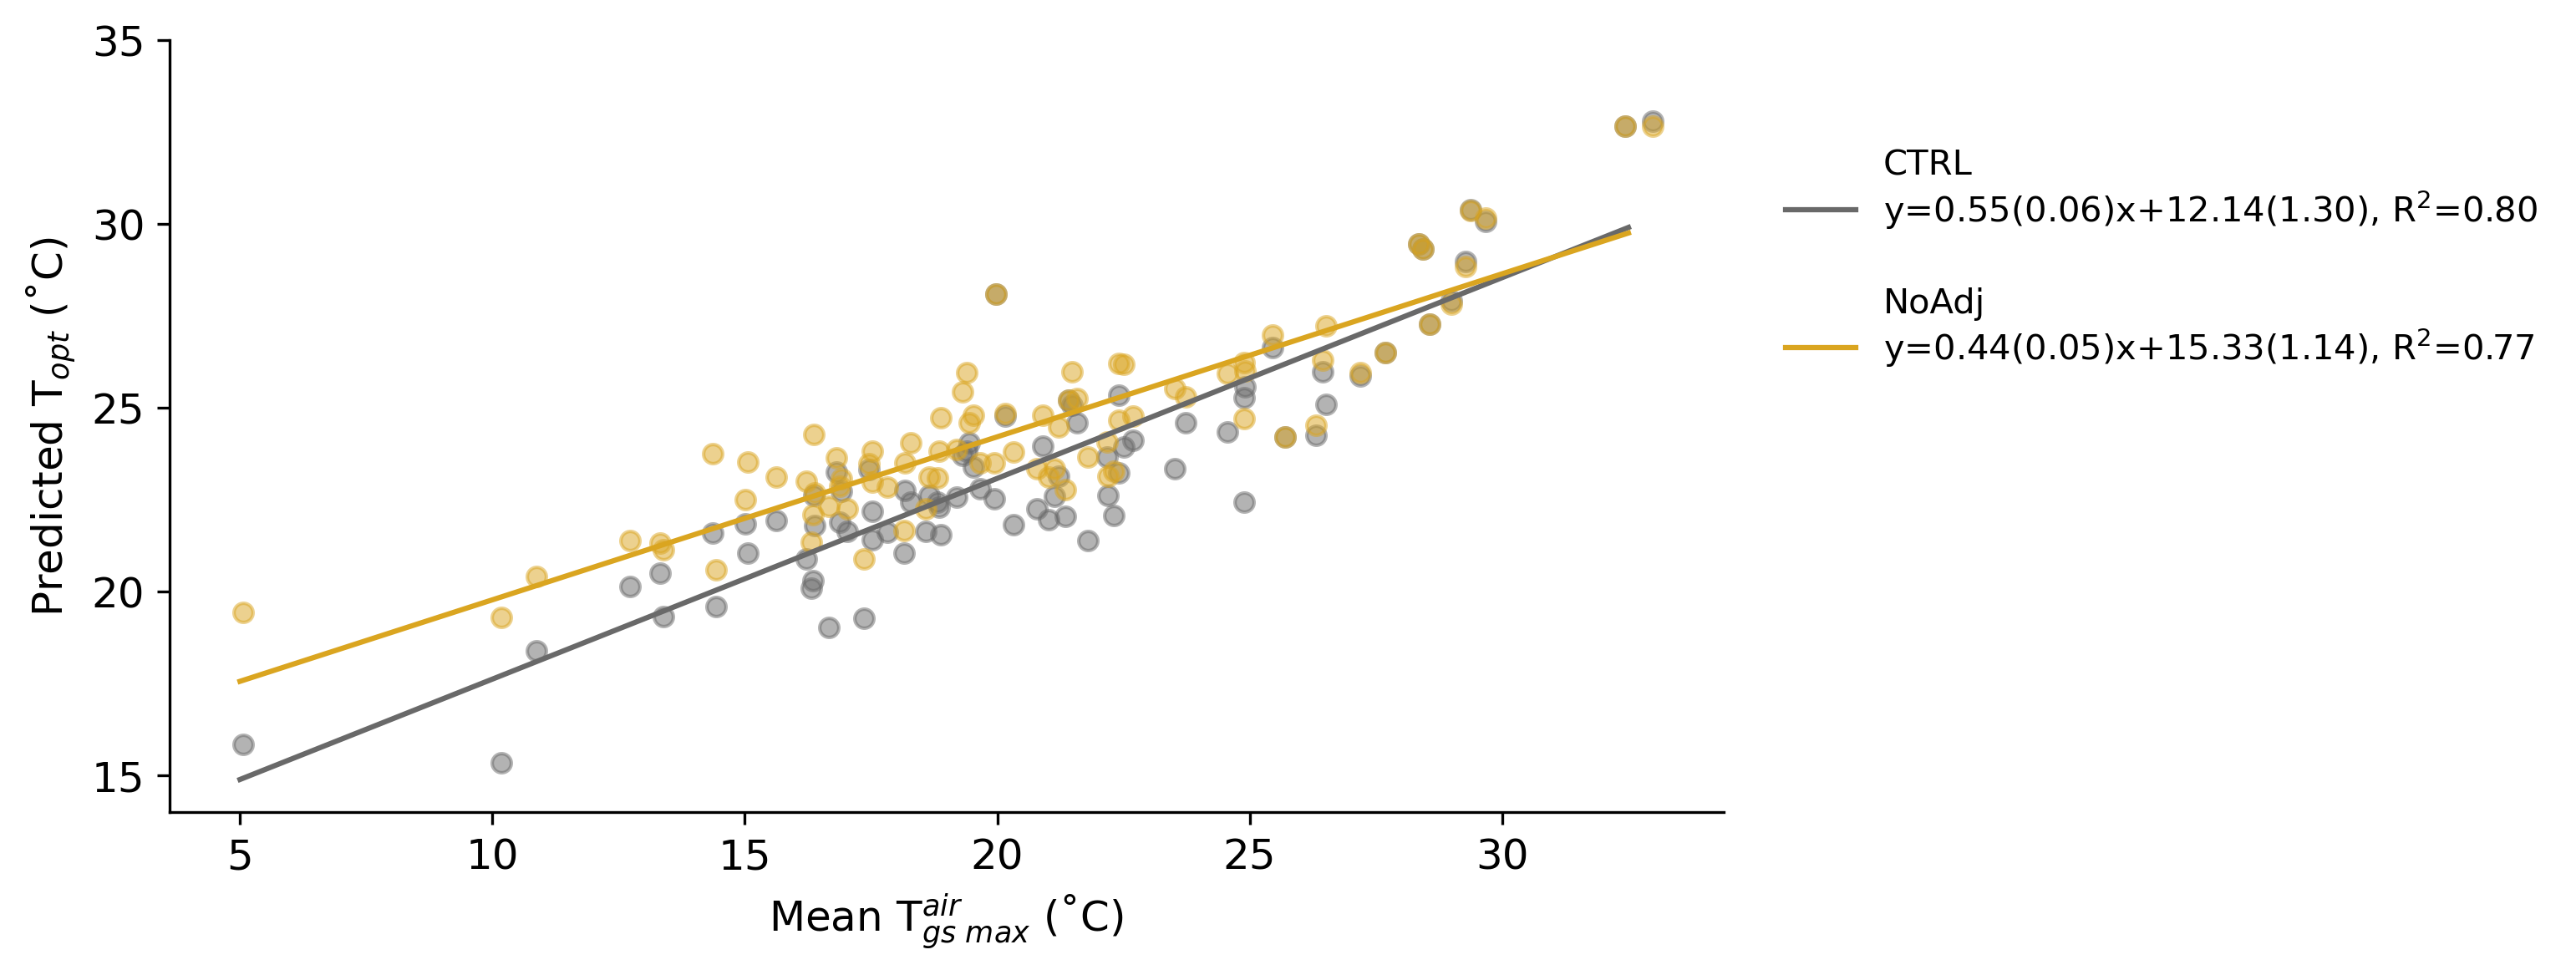

In [8]:
# for presentation


fig, ax = plt.subplots(figsize=(8,4), dpi=300)
# scatter
ax.scatter(df["Tgs_mean"], df["Topt_model_mean"], s=sz, alpha=ap, c=c1)
ax.scatter(df["Tgs_mean"], df["Topt_NoAd_mean"] , s=sz, alpha=ap, c=c2)
# ax.scatter(df["Tgs_mean"], df["Topt_Met_mean"]  , s=sz, alpha=ap, c=c3)
# ax.scatter(df["Tgs_mean"], df["Topt_Heat_mean"] , s=sz, alpha=ap, c=c4)
# reglines
ax.plot(x, y1, label=str1, c=c1)
ax.plot(x, y2, label=str2, c=c2)
# ax.plot(x, y3, label=str3, c=c3)
# ax.plot(x, y4, label=str4, c=c4)

ax.set_yticks(np.arange(15, 35.1, 5))
ax.set_xlabel("Mean T$_{gs\\ max}^{air}$ (˚C)", fontsize=12)
ax.set_ylabel("Predicted T$_{opt}$ (˚C)", fontsize=12)
ax.legend(bbox_to_anchor=(1.02, 0.9), loc='upper left', frameon=False)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [8]:
df["Topt_Heat_mean"].index[17]

'US-Ne1'

In [9]:
# NoAd
NoVPD_filename       = '/Users/hzc/data/MoreAnalysis_2024/Model_FilterOut_202409/output_202412/Canopy_defaultLAI_NoVPD_10Dec24.csv'
UniIabs_filename     = '/Users/hzc/data/MoreAnalysis_2024/Model_FilterOut_202409/output_202501/Canopy_defaultLAI_AllDayLit1250_14Jan25.csv'
Tplus10_filename     = '/Users/hzc/data/MoreAnalysis_2024/Model_FilterOut_202409/output_202501/Canopy_defaultLAI_DtcCri_TdefAndT10_13Jan25.csv'

# read out and compute mean value
NoVPD, _      = read_csv(NoVPD_filename,   "NoVPD")
UniIabs, _    = read_csv(UniIabs_filename, "UniIabs")
Tplus10, _    = read_csv(Tplus10_filename, "Tplus10")

# merge
dfs = [Tgs, Topt_model,
       Topt_NoAd, NoVPD,
       UniIabs,
       Tplus10,
       Topt_Met, Topt_Heat]
df_fac = reduce(lambda x, y: pd.merge(x, y, on="site", how="inner"), dfs)
df_fac = df_fac.dropna(axis='index',how="any") 

In [10]:
# effect on Topt
df_fac["dTopt_NoAd"]     = df_fac["Topt_NoAd_mean"] - df_fac["Topt_model_mean"]
df_fac["dTopt_NoVPD"]    = df_fac["NoVPD"] - df_fac["Topt_model_mean"]
df_fac["dTopt_UniIabs"]  = df_fac["UniIabs"] - df_fac["Topt_model_mean"]
df_fac["dTopt_Tplus10"]  = df_fac["Tplus10"] - df_fac["Topt_model_mean"]

# two full model
df_fac["dTopt_netEffect_NoAd_optMet"]         = df_fac["Topt_Met_mean"] - df_fac["Topt_model_mean"]
df_fac["dTopt_netEffect_NoAd_optMet_Tplus10"] = df_fac["Topt_Heat_mean"] - df_fac["Topt_model_mean"]

# binned by Tgs
# define bins (the right edges)
bins              = [5, 15, 20, 25, 33]

df_fac['Tgs_bin'] = pd.cut(df['Tgs_mean'], bins=bins)
bin_labels        = ["(5, 15]", "(15, 20]", "(20, 25]", "(25, 33]"]
list_of_by        = df_fac["Tgs_bin"].unique().sort_values()

df_fac

,Tgs_mean,Topt_model_mean,Topt_NoAd_mean,NoVPD,UniIabs,Tplus10,Topt_Met_mean,Topt_Heat_mean,dTopt_NoAd,dTopt_NoVPD,dTopt_UniIabs,dTopt_Tplus10,dTopt_netEffect_NoAd_optMet,dTopt_netEffect_NoAd_optMet_Tplus10,Tgs_bin
site,,,,,,,,,,,,,,,
CA-Cbo,22.299717,22.060870,23.265217,23.969565,23.965217,23.421739,26.838095,27.578261,1.204348,1.908696,1.904348,1.360870,4.777226,5.517391,"(20, 25]"
CA-DBB,19.319031,23.700000,25.425000,26.925000,25.400000,24.425000,26.500000,30.800000,1.725000,3.225000,1.700000,0.725000,2.800000,7.100000,"(15, 20]"
CA-LP1,16.375209,21.800000,22.671429,24.985714,21.642857,23.400000,27.300000,26.800000,0.871429,3.185714,-0.157143,1.600000,5.500000,5.000000,"(15, 20]"
CA-TP3,19.522423,23.380000,24.800000,23.810000,24.910000,25.210000,27.433333,28.520000,1.420000,0.430000,1.530000,1.830000,4.053333,5.140000,"(15, 20]"
CA-TPD,22.411492,23.216667,24.666667,24.266667,25.183333,25.680000,26.480000,27.000000,1.450000,1.050000,1.966667,2.463333,3.263333,3.783333,"(20, 25]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
US-Ton,22.680606,24.115385,24.769231,28.875000,23.146154,26.876923,30.670000,28.584615,0.653846,4.759615,-0.969231,2.761538,6.554615,4.469231,"(20, 25]"
US-UMB,21.348529,22.040000,22.766667,23.393333,23.866667,23.373333,26.900000,27.960000,0.726667,1.353333,1.826667,1.333333,4.860000,5.920000,"(20, 25]"
US-WCr,21.007790,21.944444,23.122222,23.233333,24.266667,24.022222,26.500000,27.300000,1.177778,1.288889,2.322222,2.077778,4.555556,5.355556,"(20, 25]"


In [11]:
def df_to_list(df, varname, by, list_of_by):
    lst = []
    for i in list_of_by:
        print(i)
        sub_lst = df.loc[df[by]==i, varname].to_list()
        lst.append(sub_lst)
    return lst

(5, 15]
(15, 20]
(20, 25]
(25, 33]
(5, 15]
(15, 20]
(20, 25]
(25, 33]
(5, 15]
(15, 20]
(20, 25]
(25, 33]
(5, 15]
(15, 20]
(20, 25]
(25, 33]
(5, 15]
(15, 20]
(20, 25]
(25, 33]
(5, 15]
(15, 20]
(20, 25]
(25, 33]


/var/folders/_9/0kmt3nz12ldgv97l8bkl3z600000gn/T/ipykernel_2016/3865937996.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(0, df_fac[ivar][0],
/var/folders/_9/0kmt3nz12ldgv97l8bkl3z600000gn/T/ipykernel_2016/3865937996.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(0, df_fac[ivar][0],
/var/folders/_9/0kmt3nz12ldgv97l8bkl3z600000gn/T/ipykernel_2016/3865937996.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.ilo

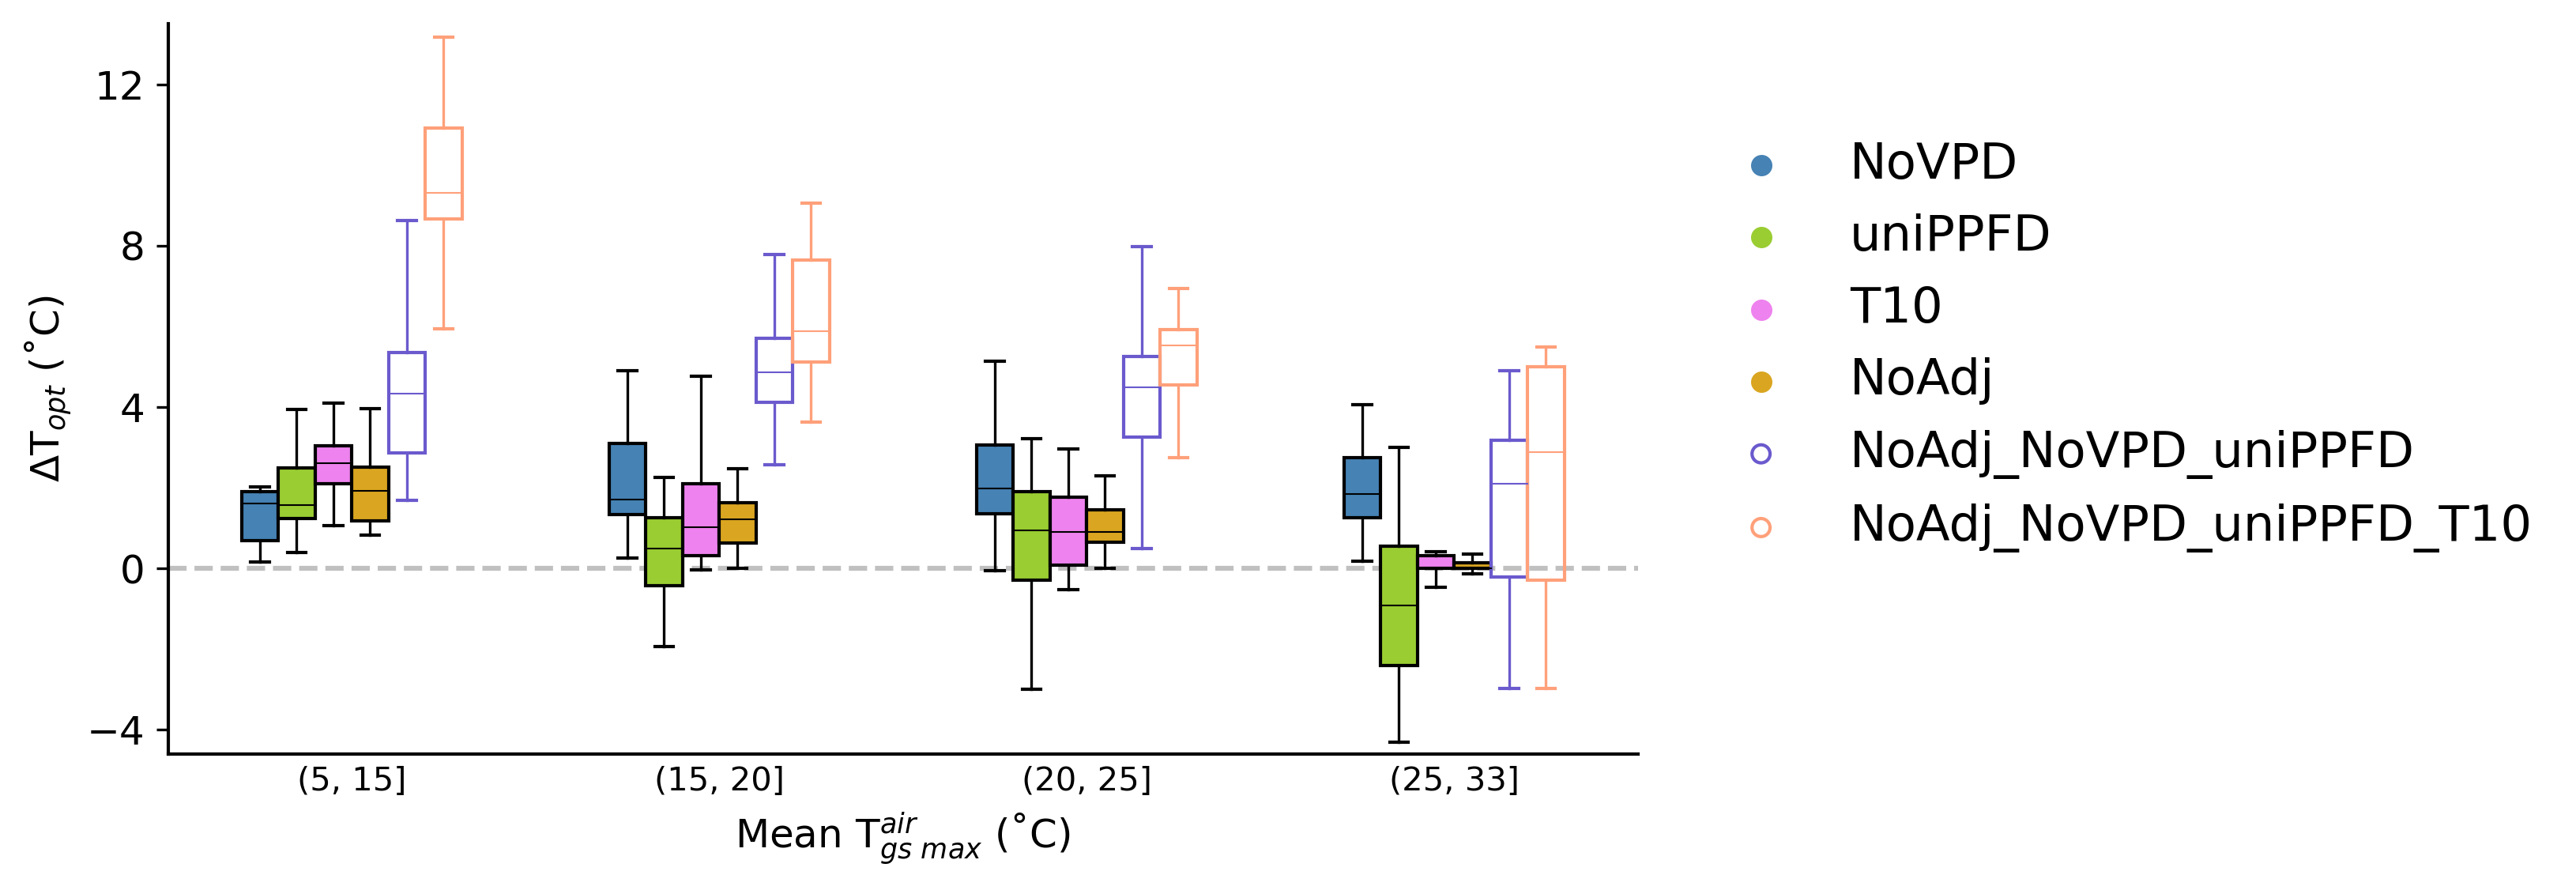

In [17]:
fig, ax = plt.subplots(figsize=(8,4), dpi=300)

varnames = ["dTopt_NoVPD", "dTopt_UniIabs", "dTopt_Tplus10", "dTopt_NoAd", "dTopt_netEffect_NoAd_optMet", "dTopt_netEffect_NoAd_optMet_Tplus10"]
colors   = ["steelblue", "yellowgreen", "violet", "goldenrod", "slateblue", "lightsalmon"]
mFill    = 4
posts    = np.array([12.5, 17.5, 22.5, 27.5])
offset   = [-1.25, -.75, -0.25, 0.25, 0.75, 1.25]
labels   = ["NoVPD", "uniPPFD", "T10",   # (two simulations combined)
            "NoAdj", 
            "NoAdj_NoVPD_uniPPFD",
            "NoAdj_NoVPD_uniPPFD_T10"]   # Combine Sim.C + Sim.D

i = 0
for ivar, offs in zip(varnames, offset):
    icolor = colors[i]
    mc     = icolor if i<mFill else "none"
    mc_inv = 'k' if i<mFill else icolor
    ilabel = labels[i]
    
    ilst = df_to_list(df_fac, ivar, "Tgs_bin", list_of_by)

    ax.boxplot(ilst, positions = posts + offs,
               sym='',
               manage_ticks=False,
               patch_artist=True,
               medianprops={"linewidth": .5, "color": mc_inv},
               boxprops={"color": mc_inv, "facecolor": mc,
                         "linewidth": 1},
               whiskerprops={"color": mc_inv,
                                "lw": 0.8},
               capprops = {"color": mc_inv},
               )
    ax.scatter(0, df_fac[ivar][0],
            s=30,
            edgecolor=icolor, c=mc,
            label=ilabel,
            )

    i += 1

# add dTopt=0
ax.hlines(y=0, xmin=10, xmax=30, linestyles="--", colors='silver', zorder=0)

ax.legend(bbox_to_anchor=(1.02, 0.9), loc='upper left', frameon=False, fontsize=15)

ax.set_xlim((10,30))
ax.set_ylim((-4.6, 13.5))

ax.set_xticks(posts)
ax.set_xticklabels(bin_labels, fontsize=10)
ax.set_xlabel("Mean T$_{gs\\ max}^{air}$ (˚C)", fontsize=12)

ax.set_yticks(np.arange(-4, 12.1, 4))
ax.set_ylabel("$\Delta$T$_{opt}$ (˚C)", fontsize=12)

ax.xaxis.set_tick_params(length=0)
ax.yaxis.set_tick_params(labelsize=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

In [13]:
keys = ["dTopt_Tplus10", "Tgs_bin"]
df_fac[keys].groupby("Tgs_bin").median(),\
df_fac["dTopt_NoVPD"].median()

/var/folders/_9/0kmt3nz12ldgv97l8bkl3z600000gn/T/ipykernel_2016/3881231269.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_fac[keys].groupby("Tgs_bin").median(),\


(          dTopt_Tplus10
 Tgs_bin                
 (5, 15]        2.607843
 (15, 20]       1.024476
 (20, 25]       0.907143
 (25, 33]       0.000000,
 1.8099999999999952)

(5, 15]
(15, 20]
(20, 25]
(25, 33]
(5, 15]
(15, 20]
(20, 25]
(25, 33]
(5, 15]
(15, 20]
(20, 25]
(25, 33]
(5, 15]
(15, 20]
(20, 25]
(25, 33]
(5, 15]
(15, 20]
(20, 25]
(25, 33]


/var/folders/_9/0kmt3nz12ldgv97l8bkl3z600000gn/T/ipykernel_2016/4005206820.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(0, df_fac[ivar][0],
/var/folders/_9/0kmt3nz12ldgv97l8bkl3z600000gn/T/ipykernel_2016/4005206820.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(0, df_fac[ivar][0],
/var/folders/_9/0kmt3nz12ldgv97l8bkl3z600000gn/T/ipykernel_2016/4005206820.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.ilo

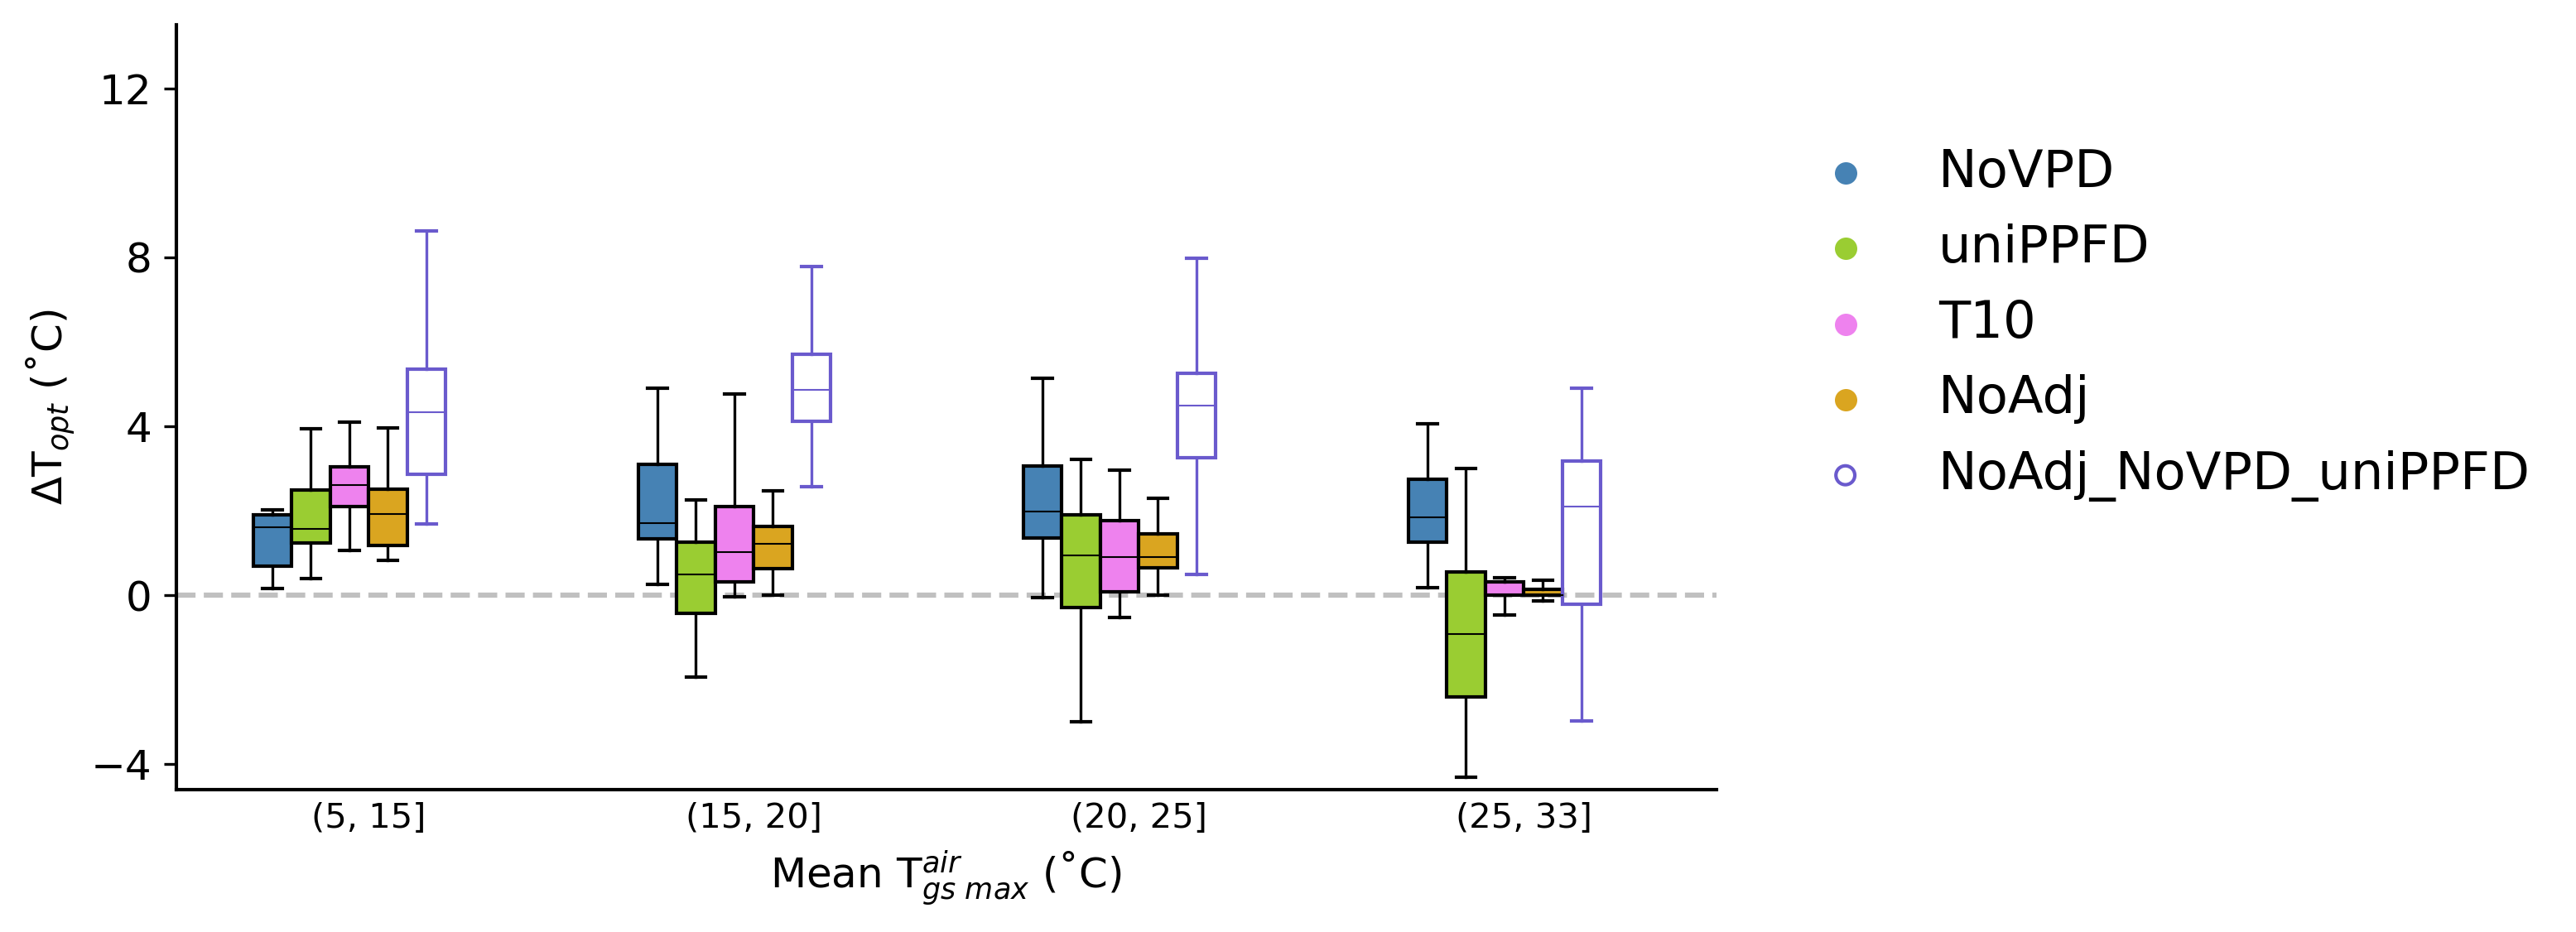

In [19]:
# modify for presentation
fig, ax = plt.subplots(figsize=(8,4), dpi=300)

varnames = ["dTopt_NoVPD", "dTopt_UniIabs", "dTopt_Tplus10", "dTopt_NoAd", "dTopt_netEffect_NoAd_optMet"]#, "dTopt_netEffect_NoAd_optMet_Tplus10"]
colors   = ["steelblue", "yellowgreen", "violet", "goldenrod", "slateblue", "lightsalmon"]
mFill    = 4
posts    = np.array([12.5, 17.5, 22.5, 27.5])
offset   = [-1.25, -.75, -0.25, 0.25, 0.75,]# 1.25]
labels   = ["NoVPD", "uniPPFD", "T10",   # (two simulations combined)
            "NoAdj", 
            "NoAdj_NoVPD_uniPPFD",
            "NoAdj_NoVPD_uniPPFD_T10"]   # Combine Sim.C + Sim.D

i = 0
for ivar, offs in zip(varnames, offset):
    icolor = colors[i]
    mc     = icolor if i<mFill else "none"
    mc_inv = 'k' if i<mFill else icolor
    ilabel = labels[i]
    
    ilst = df_to_list(df_fac, ivar, "Tgs_bin", list_of_by)

    ax.boxplot(ilst, positions = posts + offs,
               sym='',
               manage_ticks=False,
               patch_artist=True,
               medianprops={"linewidth": .5, "color": mc_inv},
               boxprops={"color": mc_inv, "facecolor": mc,
                         "linewidth": 1},
               whiskerprops={"color": mc_inv,
                                "lw": 0.8},
               capprops = {"color": mc_inv},
               )
    ax.scatter(0, df_fac[ivar][0],
            s=30,
            edgecolor=icolor, c=mc,
            label=ilabel,
            )

    i += 1

# add dTopt=0
ax.hlines(y=0, xmin=10, xmax=30, linestyles="--", colors='silver', zorder=0)

ax.legend(bbox_to_anchor=(1.02, 0.9), loc='upper left', frameon=False, fontsize=15)

ax.set_xlim((10,30))
ax.set_ylim((-4.6, 13.5))

ax.set_xticks(posts)
ax.set_xticklabels(bin_labels, fontsize=10)
ax.set_xlabel("Mean T$_{gs\\ max}^{air}$ (˚C)", fontsize=12)

ax.set_yticks(np.arange(-4, 12.1, 4))
ax.set_ylabel("$\Delta$T$_{opt}$ (˚C)", fontsize=12)

ax.xaxis.set_tick_params(length=0)
ax.yaxis.set_tick_params(labelsize=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)